# Text classification for Fake News Detection

This coursework will involve implementing functions for a text classifier, which will train to detect **fake news** in a corpus of approx. 10,000 statements, which will be split into a 80%/20% training/test split. 


In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [ ]:
def load_data(path):
    """Loading data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Spliting the data between train_data and test_data accordingly
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Input and Basic preprocessing

In [ ]:
df=pd.read_csv('fake_news.tsv',sep='\t')
display(df.head(2))

,Id,label,statement,subject,speaker,speaker_job_title,state_info,party_affiliation,total_barely_true_counts,total_false_counts total_half_true_counts,total_mostly_true_counts,total_pants_on_fire_counts,context
2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0,0,0,a mailer
10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.


In [ ]:
def convert_label(label):
   
    # Converting the multiclass labels to binary label
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }
    return labels_map[label]


def parse_data_line(data_line):
    
    labels=convert_label(data_line[1])
    return (labels,data_line[2])

In [ ]:

def pre_process(text):
    
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) # separates punctuation at ends of strings
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text) # separates punctuation at beginning of strings
    # print("tokenising:", text)
    tokens = re.split(r"\s+",text)
    # normalisation - only by lower casing for now
    tokens = [t.lower() for t in tokens]
    return tokens
    # return []

# Basic Feature Extraction

In [ ]:
global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens):
    
    local_dict={}
    for word in tokens:
      count=global_feature_dict.get(word,0)
      global_feature_dict[word]=count+1
      local_count=local_dict.get(word,0)

      local_dict[word]=local_count+1
    return local_dict

In [ ]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

# Cross-validation

In [ ]:

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score

def cross_validate(dataset, folds):
    results = []
    actual=[]
    scores=[]
    cv_results={}
    precesion=[]
    reccall=[]
    fs_core=[]
    acc=[]
    fold_size = int(len(dataset)/folds) + 1
    
    for i in range(0,len(dataset),int(fold_size)):
        
        print("Fold start on items %d - %d" % (i, i+fold_size))
        
        test_d=dataset[i:i+fold_size]
        train_d=dataset[0:i]+dataset[i+fold_size:len(dataset)]
        classifier=train_classifier(train_d)
        results=predict_labels([x[0] for x in test_d], classifier)
        actual=[x[1] for x in test_d]
        
        precision, recall, fscore, _ = precision_recall_fscore_support(actual, results, average='weighted')
        accuracy=accuracy_score(actual,results)
        
        precesion.append(precision)
        reccall.append(recall)
        fs_core.append(fscore)
        acc.append(accuracy)
        
    
    cv_results['Precesion']=np.mean(precesion)
    cv_results['Recall']=np.mean(reccall)
    cv_results['fscore']=np.mean(fs_core)
    cv_results['accuracy']=np.mean(acc) 
    
        
    return cv_results

In [ ]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [ ]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'fake_news.tsv'


# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# Cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 10241 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 10241 rawData, 8192 trainData, 2049 testData
Training Samples: 
8192
Features: 
13560


In [ ]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Fold start on items 0 - 820
Training Classifier...
Fold start on items 820 - 1640
Training Classifier...
Fold start on items 1640 - 2460
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Fold start on items 2460 - 3280
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Fold start on items 3280 - 4100
Training Classifier...
Fold start on items 4100 - 4920
Training Classifier...
Fold start on items 4920 - 5740
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Fold start on items 5740 - 6560
Training Classifier...


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Fold start on items 6560 - 7380
Training Classifier...
Fold start on items 7380 - 8200
Training Classifier...


{'Precesion': 0.5697247193999616,
 'Recall': 0.5688922263606873,
 'fscore': 0.5688818090199836,
 'accuracy': 0.5688922263606873}

# Error Analysis

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # passing labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()
    

In [ ]:
fold_size=int(len(train_data)/10)+1
test_error_data=train_data[:fold_size]
train_error_data=train_data[fold_size:]


In [ ]:
real=0
fake=0
for k in test_error_data:
  if(k[1]=='FAKE'):
    fake+=1
  else:
    real+=1
display('real',real)
display('fake',fake)

'real'

481

'fake'

339

Training Classifier...
false positives= 182
false negatives= 163


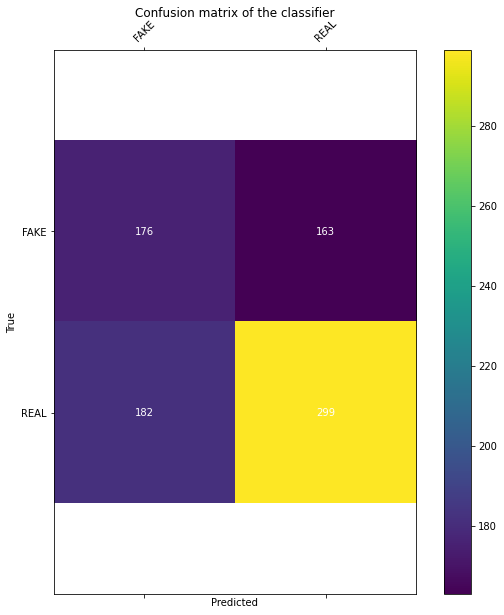

In [ ]:
lb=['REAL','FAKE']
actual=[x[1] for x in test_error_data]
error_classifier = train_classifier(train_error_data)
results = predict_labels([x[0] for x in test_error_data], error_classifier)
# print(results[2])
confusion_met=metrics.confusion_matrix(actual, results)
print('false positives=',confusion_met[1,0])
print('false negatives=',confusion_met[0,1])
confusion_matrix_heatmap(actual,results,['FAKE','REAL'])

In [ ]:
# Finally, checking the accuracy of our classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    acc=accuracy_score(test_true,test_pred)
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])
    print("Accuracy:",acc)

({'the': 2, 'bush': 1, 'tax': 1, 'cuts': 1, 'helped': 1, 'to': 1, 'create': 1, 'a': 1, 'substantial': 1, 'part': 1, 'of': 1, 'deficit': 1, '.': 1}, 'REAL')
Training Classifier...
Done training!
Precision: 0.562467
Recall: 0.562714
F Score:0.562585
Accuracy: 0.5627135187896535


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
